# Atividade Integradora

- Big Data e Computação em Nuvem / Modelos Preditivos Avançados

Insper - Jul/2020 - São Paulo, Brasil

* Autores:
    - Marcelo Franceschini
    - Rafael Costa
    - Viviane Sanchez

## Objetivo: 
Recomendar um estabelecimento bem avaliado que o usuário ainda não foi

# Ambiente Spark

In [1]:
import findspark as fs
from pyspark.sql import SparkSession

In [2]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator
import os
from pyspark.sql import SparkSession
# from pyspark.sql.types import *
from pyspark.sql import functions as f
from pyspark.sql.window import Window
from pyspark.ml.feature import StopWordsRemover
from pyspark.sql.functions import col, count, explode, split, array, concat_ws
from pyspark.sql.types import ArrayType, IntegerType
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
sns.set(style="ticks", palette="pastel")
%matplotlib inline

In [3]:
# MAC Local (Viviane)
spark_location='/Users/vivi/server/spark' # Set your own
java8_location= '/Library/Java/JavaVirtualMachines/jdk1.8.0_251.jdk/Contents/Home/' # Set your own
os.environ['JAVA_HOME'] = java8_location
fs.init(spark_home=spark_location)

In [5]:
#datapath = 'C:\\Users\\RuWindows\\Desktop\\PI\\yelp_dataset\\'  # Marcelo
# datapath = '../data/yelp' #servidor AWS
datapath = 'data' #Viviane
#files = sorted(os.listdir(datapath))
# files

### Spark Session

In [6]:
spark = SparkSession.builder \
                    .master('local[*]') \
                    .appName('Integradora Yelp') \
                    .config("spark.ui.port", "4060") \
                    .getOrCreate()
sc = spark.sparkContext
spark

## Importando as Bases Origem - Raw

In [7]:
usr_raw = spark.read.json(datapath+'/yelp_academic_dataset_user.json')
rv_raw = spark.read.json(datapath+'/yelp_academic_dataset_review.json')
bz_raw = spark.read.json(datapath+'/yelp_academic_dataset_business.json')
tp_raw = spark.read.json(datapath+'/yelp_academic_dataset_tip.json')
ch_raw = spark.read.json(datapath+'/yelp_academic_dataset_checkin.json')

usr_raw.createOrReplaceTempView('usr_raw')
rv_raw.createOrReplaceTempView('rv')
bz_raw.createOrReplaceTempView('bz_raw')
tp_raw.createOrReplaceTempView('tp')
ch_raw.createOrReplaceTempView('ch_raw')

## Visualização das estruturas de dados

In [8]:
for df in [usr_raw, rv_raw, bz_raw, tp_raw, ch_raw]:
    df.printSchema()

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)

root
 |-- business_id: string (nullable = true)
 |-- cool: long (null

In [9]:
# Verificando o SQL
for table in spark.catalog.listTables():
    print(table)

Table(name='bz_raw', database=None, description=None, tableType='TEMPORARY', isTemporary=True)
Table(name='ch_raw', database=None, description=None, tableType='TEMPORARY', isTemporary=True)
Table(name='rv', database=None, description=None, tableType='TEMPORARY', isTemporary=True)
Table(name='tp', database=None, description=None, tableType='TEMPORARY', isTemporary=True)
Table(name='usr_raw', database=None, description=None, tableType='TEMPORARY', isTemporary=True)


# Tratamento das bases

## Check-ins

- Explosão das datas na base

In [10]:
ch = ch_raw.withColumn('dt', f.explode(f.split(f.col('date'), ', ')))
ch.createOrReplaceTempView('ch')

In [11]:
ch_raw.show(2)  # Before
ch.show(2)     # After

+--------------------+--------------------+
|         business_id|                date|
+--------------------+--------------------+
|--1UhMGODdWsrMast...|2016-04-26 19:49:...|
|--6MefnULPED_I942...|2011-06-04 18:22:...|
+--------------------+--------------------+
only showing top 2 rows

+--------------------+--------------------+-------------------+
|         business_id|                date|                 dt|
+--------------------+--------------------+-------------------+
|--1UhMGODdWsrMast...|2016-04-26 19:49:...|2016-04-26 19:49:16|
|--1UhMGODdWsrMast...|2016-04-26 19:49:...|2016-08-30 18:36:57|
+--------------------+--------------------+-------------------+
only showing top 2 rows



In [12]:
ch1 = spark.sql('''
SELECT business_id, 
       dt, 
       Date(dt)      AS date, 
       Dayofweek(dt) AS dow, 
       Month(dt)     AS month, 
       Year(dt)      AS year, 
       Hour(dt)      AS hour, 
       Day(dt)       AS day 
FROM   ch 
''')
ch1.createOrReplaceTempView('ch1')
ch1.show(2)

+--------------------+-------------------+----------+---+-----+----+----+---+
|         business_id|                 dt|      date|dow|month|year|hour|day|
+--------------------+-------------------+----------+---+-----+----+----+---+
|--1UhMGODdWsrMast...|2016-04-26 19:49:16|2016-04-26|  3|    4|2016|  19| 26|
|--1UhMGODdWsrMast...|2016-08-30 18:36:57|2016-08-30|  3|    8|2016|  18| 30|
+--------------------+-------------------+----------+---+-----+----+----+---+
only showing top 2 rows



In [13]:
ch2 = spark.sql('''
SELECT business_id, 
       year, 
       month, 
       dow, 
       day, 
       Count(date) AS count 
FROM   ch1 
GROUP  BY business_id, 
          year, 
          month, 
          dow, 
          day 
ORDER  BY count DESC 
''')
ch2.createOrReplaceTempView('ch2')
ch2.show(2)

+--------------------+----+-----+---+---+-----+
|         business_id|year|month|dow|day|count|
+--------------------+----+-----+---+---+-----+
|RESDUcs7fIiihp38-...|2019|   10|  1|  6|  288|
|K2PHx0JgNuZh7b89g...|2017|    7|  7| 15|  264|
+--------------------+----+-----+---+---+-----+
only showing top 2 rows



### Analisando o movimento de um estabelecimento

In [14]:
df = spark.sql('''
SELECT * 
FROM   ch2 
WHERE  business_id = 'BxCzy1WOVxOrr_G7V4BIvg' 
''').toPandas()

In [15]:
df2 = df.groupby(['month', 'dow'])['count'].sum().unstack('dow').fillna(0)

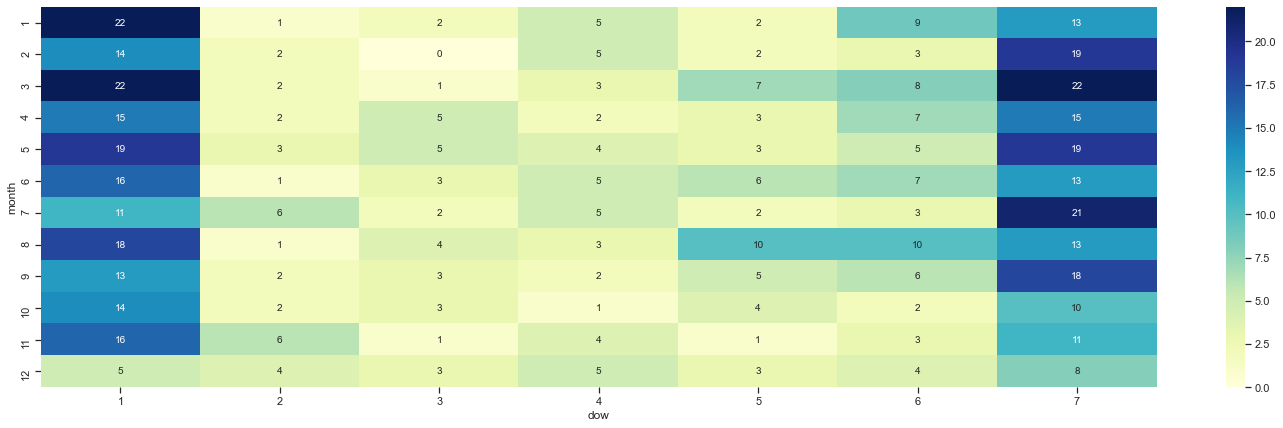

In [16]:
plt.figure(figsize=(25, 7))
sns.heatmap(data=df2, cmap="YlGnBu", annot=True)

Pelo gráfico, verfica-se que o local é ais movimentado em janeiro, principalmente aos finais de semana. Para simplicar, será utilzada a média de checkins dos estabelecimentos. Para a modelagem, o ideal seria utilizar a moda (valor mais frequente) dos check-ins. A média pode não ser representativa, pois o pico de movimento está concentrado aos finais de semana, portanto essa informação não será utilizada na modelagem.

### Média de movimento diário por estabelecimento

In [17]:
ch2.show(5)

+--------------------+----+-----+---+---+-----+
|         business_id|year|month|dow|day|count|
+--------------------+----+-----+---+---+-----+
|RESDUcs7fIiihp38-...|2019|   10|  1|  6|  288|
|K2PHx0JgNuZh7b89g...|2017|    7|  7| 15|  264|
|RESDUcs7fIiihp38-...|2019|    9|  1|  1|  263|
|RESDUcs7fIiihp38-...|2019|   10|  7|  5|  261|
|RESDUcs7fIiihp38-...|2019|    8|  7| 31|  246|
+--------------------+----+-----+---+---+-----+
only showing top 5 rows



In [18]:
ch3 = spark.sql('''
SELECT business_id, 
       Avg(count) AS avg_frequency 
FROM   ch2 
WHERE  year >= 2017 
GROUP  BY business_id 
ORDER  BY avg_frequency DESC 
''')
ch3.createOrReplaceTempView('ch3')
ch3.show(5)

+--------------------+-----------------+
|         business_id|    avg_frequency|
+--------------------+-----------------+
|_GdzDB3SU9Ni7mAOQ...|            106.0|
|ndjiWXoH1pPMwEBhR...|             87.0|
|K2PHx0JgNuZh7b89g...|65.36363636363636|
|33Pq0cQn3jODiIG7V...|56.46969696969697|
|saOyWIFTUHGMhRnGT...|             53.0|
+--------------------+-----------------+
only showing top 5 rows



## Tips

In [21]:
tp_raw.show(7)

+--------------------+----------------+-------------------+--------------------+--------------------+
|         business_id|compliment_count|               date|                text|             user_id|
+--------------------+----------------+-------------------+--------------------+--------------------+
|UYX5zL_Xj9WEc_Wp-...|               0|2013-11-26 18:20:08|Here for a quick mtg|hf27xTME3EiCp6NL6...|
|Ch3HkwQYv1YKw_FO0...|               0|2014-06-15 22:26:45|Cucumber strawber...|uEvusDwoSymbJJ0au...|
|rDoT-MgxGRiYqCmi0...|               0|2016-07-18 22:03:42|Very nice good se...|AY-laIws3S7YXNl_f...|
|OHXnDV01gLokiX1EL...|               0|2014-06-06 01:10:34|It's a small plac...|Ue_7yUlkEbX4AhnYd...|
|GMrwDXRlAZU2zj5nH...|               0|2011-04-08 18:12:01|8 sandwiches, $24...|LltbT_fUMqZ-ZJP-v...|
|ALwAlxItASeEs2vYA...|               0|2015-05-20 20:17:38|Great ramen! Not ...|HHNBqfbDR8b1iq-QG...|
|d_L-rfS1vT3JMzgCU...|               0|2014-09-01 01:23:48|Cochinita Pibil w...|r0

- Quantidade de tips por estabelecimento e usuário

In [23]:
tp_usr = spark.sql('''
SELECT user_id, 
       Count(text)           AS tips_counter, 
       Sum(compliment_count) AS total_compliments 
FROM   tp 
GROUP  BY user_id 
ORDER  BY total_compliments DESC 
''')
tp_usr.show(5)

+--------------------+------------+-----------------+
|             user_id|tips_counter|total_compliments|
+--------------------+------------+-----------------+
|mkbx55W8B8aPLgDqe...|        2664|             1358|
|zFYs8gSUYDvXkb6O7...|         453|              196|
|0tvCcnfJnSs55iB6m...|        1602|              165|
|R5WcogaoAwjdHxrB2...|         497|              162|
|A0j21z2Q1HGic7jW6...|        1005|              159|
+--------------------+------------+-----------------+
only showing top 5 rows



In [24]:
tp_bz = spark.sql('''
SELECT business_id, 
       Count(text)           AS tips_counter, 
       Sum(compliment_count) AS total_compliments 
FROM   tp
GROUP  BY business_id 
ORDER  BY total_compliments DESC 
''')
tp_bz.createOrReplaceTempView('tp_bz')
tp_bz.show()

+--------------------+------------+-----------------+
|         business_id|tips_counter|total_compliments|
+--------------------+------------+-----------------+
|BQqwIYQuo2W94smjr...|         128|               68|
|FaHADZARwnY4yvlvp...|        3679|               55|
|RESDUcs7fIiihp38-...|        1386|               54|
|55E0-qUHa7Kzqz8rO...|         329|               40|
|QhXBIQWUmQxuVErdw...|          76|               36|
|DN0b4Un8--Uf6SEWL...|         328|               36|
|MpmFFw0GE_2iRFPds...|         696|               35|
|JmI9nslLD7KZqRr__...|        2494|               35|
|DfgZlNgKwBvCpA_0a...|         442|               31|
|QsKhwKYB3YeWXqpIP...|          78|               31|
|OMRYQihVjqqzjoNoQ...|         101|               30|
|awI4hHMfa7H0Xf0-C...|         745|               28|
|O7UMzd3i-Zk8dMeyY...|         240|               26|
|X8c23dur0ll2D9XTu...|         298|               26|
|t-o_Sraneime4DDhW...|         648|               24|
|iCQpiavjjPzJ5_3gP...|      

## Business

### Abertura dos atributos e horários para colunas

In [25]:
dfs = []

for x in ["hours", "attributes"]:
    cols = bz_raw.select(f"{x}.*").columns
    for col in cols:
        try:
            dfs.append(dfs[-1].withColumn(col, f.col(f"{x}.{col}")))
        except IndexError:
            dfs.append(bz_raw.withColumn(col, f.col(f"{x}.{col}")))

bz = dfs[-1].drop("hours", "attributes")
bz.createOrReplaceTempView("bz")
bz.printSchema()

root
 |-- address: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- city: string (nullable = true)
 |-- is_open: long (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- name: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- stars: double (nullable = true)
 |-- state: string (nullable = true)
 |-- Friday: string (nullable = true)
 |-- Monday: string (nullable = true)
 |-- Saturday: string (nullable = true)
 |-- Sunday: string (nullable = true)
 |-- Thursday: string (nullable = true)
 |-- Tuesday: string (nullable = true)
 |-- Wednesday: string (nullable = true)
 |-- AcceptsInsurance: string (nullable = true)
 |-- AgesAllowed: string (nullable = true)
 |-- Alcohol: string (nullable = true)
 |-- Ambience: string (nullable = true)
 |-- BYOB: string (nullable = true)
 |-- BYOBCorkage: string (nullable = true)

### Limpeza e padronização dos atributos

In [26]:
bz1 = spark.sql('''
SELECT * 
FROM   bz 
WHERE  city == 'Toronto' 
       AND is_open == 1 
''')

In [27]:
bz1.groupBy('is_open').count().show()

+-------+-----+
|is_open|count|
+-------+-----+
|      1|14962|
+-------+-----+



In [28]:
cols = bz_raw.select('attributes.*').columns
cols

['AcceptsInsurance',
 'AgesAllowed',
 'Alcohol',
 'Ambience',
 'BYOB',
 'BYOBCorkage',
 'BestNights',
 'BikeParking',
 'BusinessAcceptsBitcoin',
 'BusinessAcceptsCreditCards',
 'BusinessParking',
 'ByAppointmentOnly',
 'Caters',
 'CoatCheck',
 'Corkage',
 'DietaryRestrictions',
 'DogsAllowed',
 'DriveThru',
 'GoodForDancing',
 'GoodForKids',
 'GoodForMeal',
 'HairSpecializesIn',
 'HappyHour',
 'HasTV',
 'Music',
 'NoiseLevel',
 'Open24Hours',
 'OutdoorSeating',
 'RestaurantsAttire',
 'RestaurantsCounterService',
 'RestaurantsDelivery',
 'RestaurantsGoodForGroups',
 'RestaurantsPriceRange2',
 'RestaurantsReservations',
 'RestaurantsTableService',
 'RestaurantsTakeOut',
 'Smoking',
 'WheelchairAccessible',
 'WiFi']

- Valores únicos em cada coluna de atributos. As colunas que contém listas serão desconsideradas da base para facilitar a análise. As demais serão codificadas conforme a seguir:

    - Null/None: 0
    - False: 1
    - True: 2
    
As colunas que possuem uma descrição das características serão tratadas individualmente.

In [29]:
[bz1.groupBy(cols[x]).count().show() for x in range(len(cols))]

+----------------+-----+
|AcceptsInsurance|count|
+----------------+-----+
|            None|    2|
|           False|   97|
|            null|14531|
|            True|  332|
+----------------+-----+

+-----------+-----+
|AgesAllowed|count|
+-----------+-----+
|       null|14954|
| u'allages'|    1|
|  u'19plus'|    7|
+-----------+-----+

+----------------+-----+
|         Alcohol|count|
+----------------+-----+
|            None|    5|
|         u'none'| 1398|
|            null|10876|
| 'beer_and_wine'|  127|
|          'none'|  358|
|u'beer_and_wine'|  445|
|     u'full_bar'| 1599|
|      'full_bar'|  154|
+----------------+-----+

+--------------------+-----+
|            Ambience|count|
+--------------------+-----+
|{'touristy': None...|    1|
|{'touristy': None...|    1|
|{'touristy': Fals...|    1|
|{'touristy': Fals...|    1|
|{'touristy': Fals...|   13|
|{'touristy': Fals...|    1|
|{'touristy': Fals...|   15|
|{'touristy': Fals...|    1|
|{'touristy': None...|    1|
|{'touris

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [30]:
unwanted = ['Ambience', 'BestNights', 'BusinessAcceptsBitcoin', 'BusinessParking', 'BYOBCorkage',
            'DietaryRestrictions', 'GoodForMeal', 'HairSpecializesIn', 'Music', 'Open24Hours', 'RestaurantsCounterService']

In [31]:
bz2 = bz1.drop('Ambience', 'BestNights', 'BusinessAcceptsBitcoin', 'BusinessParking', 'BYOBCorkage', 'DietaryRestrictions', 'GoodForMeal', 'HairSpecializesIn', 'Music', 'Open24Hours', 'RestaurantsCounterService',
               'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'address', 'postal_code', 'state', 'city', 'is_open')

In [32]:
for col in unwanted:
    cols.remove(col)

In [33]:
bz3 = bz2.fillna('0')

In [34]:
bz4 = bz3.replace({'True': '2', 'False': '1', 'None': '0', 'null': '0'}, cols)

/Users/vivi/anaconda3/lib/python3.7/site-packages/pyspark/sql/dataframe.py:1800: UserWarning: to_replace is a dict and value is not None. value will be ignored.
  warnings.warn("to_replace is a dict and value is not None. value will be ignored.")


In [35]:
bz5 = bz4.withColumn('AgesAllowed', f.regexp_replace(
    f.col('AgesAllowed'), "u'allages'", '0'))
bz6 = bz5.withColumn('AgesAllowed', f.regexp_replace(
    f.col('AgesAllowed'), "u'19plus'", '19'))

In [36]:
bz7 = bz6.withColumn('Alcohol', f.regexp_replace(
    f.col('Alcohol'), "'none'|u'none'", '0'))
bz8 = bz7.withColumn('Alcohol', f.regexp_replace(
    f.col('Alcohol'), "'beer_and_wine'|u'beer_and_wine'", '1'))
bz9 = bz8.withColumn('Alcohol', f.regexp_replace(
    f.col('Alcohol'), "'full_bar'|u'full_bar'", '2'))

In [37]:
bz10 = bz9.withColumn('NoiseLevel', f.regexp_replace(
    f.col('NoiseLevel'), "'quiet'|u'quiet'", '1'))
bz11 = bz10.withColumn('NoiseLevel', f.regexp_replace(
    f.col('NoiseLevel'), "'average'|u'average'", '2'))
bz12 = bz11.withColumn('NoiseLevel', f.regexp_replace(
    f.col('NoiseLevel'), "'very_loud'|u'very_loud'", '4'))
bz13 = bz12.withColumn('NoiseLevel', f.regexp_replace(
    f.col('NoiseLevel'), "'loud'|u'loud'", '3'))

In [38]:
bz14 = bz13.withColumn('Smoking', f.regexp_replace(
    f.col('Smoking'), "'no'|u'no'", '1'))
bz15 = bz14.withColumn('Smoking', f.regexp_replace(
    f.col('Smoking'), "'outdoor'|u'outdoor'", '2'))
bz16 = bz15.withColumn('Smoking', f.regexp_replace(
    f.col('Smoking'), "'yes'|u'yes'", '3'))

In [39]:
bz17 = bz16.withColumn('WiFi', f.regexp_replace(
    f.col('WiFi'), "'no'|u'no'", '1'))
bz18 = bz17.withColumn('WiFi', f.regexp_replace(
    f.col('WiFi'), "'paid'|u'paid'", '2'))
bz19 = bz18.withColumn('WiFi', f.regexp_replace(
    f.col('WiFi'), "'free'|u'free'", '3'))

In [40]:
bz20 = bz19.withColumn('RestaurantsAttire', f.regexp_replace(
    f.col('WiFi'), "'casual'|u'casual'", '1'))
bz21 = bz20.withColumn('RestaurantsAttire', f.regexp_replace(
    f.col('WiFi'), "'dressy'|u'dressy'", '2'))
bz22 = bz21.withColumn('RestaurantsAttire', f.regexp_replace(
    f.col('WiFi'), "'formal'|u'formal'", '3'))

In [41]:
#[bz22.groupBy(cols[x]).count().show() for x in range(len(cols))]

In [42]:
bz22.createOrReplaceTempView('bz22')

### Join da quantidade de tips por estabelecimento

In [46]:
bz23 = spark.sql('''
SELECT A.*, 
       B.tips_counter, 
       B.total_compliments 
FROM   bz22 AS A 
       LEFT JOIN tp_bz AS B 
              ON A.business_id = B.business_id 
''')

In [47]:
bz23.columns

['business_id',
 'categories',
 'latitude',
 'longitude',
 'name',
 'review_count',
 'stars',
 'AcceptsInsurance',
 'AgesAllowed',
 'Alcohol',
 'BYOB',
 'BikeParking',
 'BusinessAcceptsCreditCards',
 'ByAppointmentOnly',
 'Caters',
 'CoatCheck',
 'Corkage',
 'DogsAllowed',
 'DriveThru',
 'GoodForDancing',
 'GoodForKids',
 'HappyHour',
 'HasTV',
 'NoiseLevel',
 'OutdoorSeating',
 'RestaurantsAttire',
 'RestaurantsDelivery',
 'RestaurantsGoodForGroups',
 'RestaurantsPriceRange2',
 'RestaurantsReservations',
 'RestaurantsTableService',
 'RestaurantsTakeOut',
 'Smoking',
 'WheelchairAccessible',
 'WiFi',
 'tips_counter',
 'total_compliments']

In [49]:
bz23.write \
    .format('csv') \
    .mode('overwrite') \
    .option('sep', ',') \
    .option('header', True) \
    .save('output/yelp_bz.csv')

In [50]:
bz23.createOrReplaceTempView('bz')

## Users

### Seleção e tratamento da variáveis

In [62]:
# Transforma variáveis para serem utilizadas na Matriz de Distâncias - H Clust
# Arrays em Numéricas - "id" de friends para friends_count
# Arrays em Numéricas - "ano" de elite para elite_count
# Data em Numéricas do ano - "yelping_since" para "year_since"

usr_raw1 = usr_raw.withColumn(
    'friends_count', f.size(f.split(f.col('friends'), ' ')))
usr_raw1 = usr_raw1.withColumn(
    'elite_count', f.size(f.split(f.col('elite'), ',')))
usr_raw1 = usr_raw1.withColumn('year_since', f.year('yelping_since'))

# usr_raw1.show()

In [63]:
usr_raw1.createOrReplaceTempView('usr_raw1')

- Seleção variáveis que serão utilizadas na clusterização

In [64]:
usr_base = spark.sql('''
SELECT A.user_id, 
       A.average_stars, 
       A.compliment_cool, 
       A.compliment_cute, 
       A.compliment_funny, 
       A.compliment_hot, 
       A.compliment_list, 
       A.compliment_more, 
       A.compliment_note, 
       A.compliment_photos, 
       A.compliment_plain, 
       A.compliment_profile, 
       A.compliment_writer, 
       A.cool, 
       A.elite_count, 
       A.fans, 
       A.friends_count, 
       A.funny, 
       A.review_count AS review_count_usr, 
       A.useful, 
       A.year_since, 
       B.business_id 
FROM   usr_raw1 AS A 
       LEFT JOIN rv AS B 
              ON A.user_id = B.user_id 
''')
usr_base.createOrReplaceTempView('usr_base')

In [65]:
spark.sql('''
SELECT Count(DISTINCT user_id) 
FROM   usr_base 
''').show()

+-----------------------+
|count(DISTINCT user_id)|
+-----------------------+
|                1968703|
+-----------------------+



- Seleção de usuários com reviews de business IDs em Toronto, já selecionados anteriormente na base de estabelecimentos

In [66]:
usr_base2 = spark.sql('''
SELECT A.business_id, 
       B.* 
FROM   bz AS A 
       LEFT JOIN usr_base AS B 
              ON A.business_id = B.business_id 
''')

usr_base2.createOrReplaceTempView('usr_base2')

In [67]:
spark.sql('''
SELECT Count(DISTINCT user_id) 
FROM   usr_base2 
''').show()

+-----------------------+
|count(DISTINCT user_id)|
+-----------------------+
|                 119792|
+-----------------------+



In [68]:
# Identificar User_id Apenas de Usuários que fizeram Reviews em Estabelecimentos Abertos Em Toronto

usr_base3 = spark.sql('''
SELECT DISTINCT user_id 
FROM   usr_base2 
''')

usr_base3.createOrReplaceTempView('usr_base3')

In [69]:
# Seleciona Apenas de Usuários que fizeram Reviews em Estabelecimentos Abertos Em Toronto

usr_base4 = spark.sql('''
SELECT A.user_id, 
       A.average_stars, 
       A.compliment_cool, 
       A.compliment_cute, 
       A.compliment_funny, 
       A.compliment_hot, 
       A.compliment_list, 
       A.compliment_more, 
       A.compliment_note, 
       A.compliment_photos, 
       A.compliment_plain, 
       A.compliment_profile, 
       A.compliment_writer, 
       A.cool, 
       A.elite_count, 
       A.fans, 
       A.friends_count, 
       A.funny, 
       A.review_count AS review_count_usr, 
       A.useful, 
       A.year_since 
FROM   usr_raw1 AS A 
       LEFT JOIN usr_base3 AS B 
              ON A.user_id = B.user_id 
WHERE  B.user_id <> '' 
''')
usr_base4.createOrReplaceTempView('usr_base4')

- Quantidade inicial de usuários na base:

In [70]:
spark.sql('''
SELECT Count(DISTINCT user_id) 
FROM   usr_raw1 
''').show()

+-----------------------+
|count(DISTINCT user_id)|
+-----------------------+
|                1968703|
+-----------------------+



- Quantidade final de usuários na base:

In [71]:
spark.sql('''
SELECT Count(DISTINCT user_id) 
FROM   usr_base4 
''').show()

+-----------------------+
|count(DISTINCT user_id)|
+-----------------------+
|                 119792|
+-----------------------+



In [72]:
usr_base4.write \
    .format('csv') \
    .mode('overwrite') \
    .option('sep', ',') \
    .option('header', True) \
    .save('output/yelp_usr.csv')

## Base para treino do modelo

In [56]:
usr_clusters = spark.read.csv('output/usr_cluster.csv', header=True)
usr_clusters.createOrReplaceTempView('usr_clusters')

In [57]:
# Juntando número do cluster na base de usuários
usr_clusters2 = spark.sql("""
SELECT A.*, 
       B.cluster AS cluster_usr 
FROM   usr_base4 AS A 
       LEFT JOIN usr_clusters AS B 
              ON A.user_id = B.user_id 
""")

usr_clusters2.createOrReplaceTempView('usr_clusters2')

In [58]:
# seleção das reviews daqueles usuários
bf1 = spark.sql("""
SELECT B.*, 
       A.business_id, 
       A.stars      AS stars_rv, 
       Year(A.date) AS year_rv 
FROM   usr_clusters2 AS B 
       LEFT JOIN rv AS A 
              ON B.user_id = A.user_id 
""")

bf1.createOrReplaceTempView('bf1')

In [59]:
bf2 = spark.sql('''
SELECT A.*, 
       B.categories, 
       B.latitude, 
       B.longitude, 
       B.NAME, 
       B.review_count, 
       B.stars, 
       B.acceptsinsurance, 
       B.agesallowed, 
       B.alcohol, 
       B.byob, 
       B.bikeparking, 
       B.businessacceptscreditcards, 
       B.byappointmentonly, 
       B.caters, 
       B.coatcheck, 
       B.corkage, 
       B.dogsallowed, 
       B.drivethru, 
       B.goodfordancing, 
       B.goodforkids, 
       B.happyhour, 
       B.hastv, 
       B.noiselevel, 
       B.outdoorseating, 
       B.restaurantsattire, 
       B.restaurantsdelivery, 
       B.restaurantsgoodforgroups, 
       B.restaurantspricerange2, 
       B.restaurantsreservations, 
       B.restaurantstableservice, 
       B.restaurantstakeout, 
       B.smoking, 
       B.wheelchairaccessible, 
       B.wifi 
FROM   bf1 AS A 
       RIGHT JOIN bz22 AS B 
               ON A.business_id = B.business_id 
WHERE  year_rv >= 2017 
''')

bf2.createOrReplaceTempView('bf2')

In [60]:
# bf1.groupBy('cluster_bz').count().show()

In [61]:
spark.sql('''
SELECT Count(DISTINCT business_id) 
FROM   bf2 
''').show()

+---------------------------+
|count(DISTINCT business_id)|
+---------------------------+
|                      13428|
+---------------------------+



In [62]:
bf2.columns

['user_id',
 'average_stars',
 'compliment_cool',
 'compliment_cute',
 'compliment_funny',
 'compliment_hot',
 'compliment_list',
 'compliment_more',
 'compliment_note',
 'compliment_photos',
 'compliment_plain',
 'compliment_profile',
 'compliment_writer',
 'cool',
 'elite_count',
 'fans',
 'friends_count',
 'funny',
 'review_count_usr',
 'useful',
 'year_since',
 'cluster_usr',
 'business_id',
 'stars_rv',
 'year_rv',
 'categories',
 'latitude',
 'longitude',
 'NAME',
 'review_count',
 'stars',
 'acceptsinsurance',
 'agesallowed',
 'alcohol',
 'byob',
 'bikeparking',
 'businessacceptscreditcards',
 'byappointmentonly',
 'caters',
 'coatcheck',
 'corkage',
 'dogsallowed',
 'drivethru',
 'goodfordancing',
 'goodforkids',
 'happyhour',
 'hastv',
 'noiselevel',
 'outdoorseating',
 'restaurantsattire',
 'restaurantsdelivery',
 'restaurantsgoodforgroups',
 'restaurantspricerange2',
 'restaurantsreservations',
 'restaurantstableservice',
 'restaurantstakeout',
 'smoking',
 'wheelchairaccess

In [63]:
bf2.write \
    .format('csv') \
    .mode('overwrite') \
    .option('sep', ',') \
    .option('header', True) \
    .save('output/yelp.csv')

Py4JJavaError: An error occurred while calling o548.save.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:198)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:159)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:104)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:102)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.doExecute(commands.scala:122)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:83)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:81)
	at org.apache.spark.sql.DataFrameWriter$$anonfun$runCommand$1.apply(DataFrameWriter.scala:676)
	at org.apache.spark.sql.DataFrameWriter$$anonfun$runCommand$1.apply(DataFrameWriter.scala:676)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:80)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:127)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:75)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:676)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:285)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:271)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:229)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.lang.StackOverflowError
	at org.codehaus.janino.CodeContext.extract16BitValue(CodeContext.java:700)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:484)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:557)
	at org.codehaus.janino.CodeContext.flowAnalysis(CodeContext.java:328)
	at org.codehaus.janino.UnitCompiler.compile(UnitCompiler.java:3417)
	at org.codehaus.janino.UnitCompiler.compileDeclaredMethods(UnitCompiler.java:1357)
	at org.codehaus.janino.UnitCompiler.compileDeclaredMethods(UnitCompiler.java:1330)
	at org.codehaus.janino.UnitCompiler.compile2(UnitCompiler.java:822)
	at org.codehaus.janino.UnitCompiler.compile2(UnitCompiler.java:981)
	at org.codehaus.janino.UnitCompiler.access$700(UnitCompiler.java:215)
	at org.codehaus.janino.UnitCompiler$2.visitMemberClassDeclaration(UnitCompiler.java:414)
	at org.codehaus.janino.UnitCompiler$2.visitMemberClassDeclaration(UnitCompiler.java:406)
	at org.codehaus.janino.Java$MemberClassDeclaration.accept(Java.java:1295)
	at org.codehaus.janino.UnitCompiler.compile(UnitCompiler.java:406)
	at org.codehaus.janino.UnitCompiler.compileDeclaredMemberTypes(UnitCompiler.java:1306)
	at org.codehaus.janino.UnitCompiler.compile2(UnitCompiler.java:848)
	at org.codehaus.janino.UnitCompiler.compile2(UnitCompiler.java:432)
	at org.codehaus.janino.UnitCompiler.access$400(UnitCompiler.java:215)
	at org.codehaus.janino.UnitCompiler$2.visitPackageMemberClassDeclaration(UnitCompiler.java:411)
	at org.codehaus.janino.UnitCompiler$2.visitPackageMemberClassDeclaration(UnitCompiler.java:406)
	at org.codehaus.janino.Java$PackageMemberClassDeclaration.accept(Java.java:1414)
	at org.codehaus.janino.UnitCompiler.compile(UnitCompiler.java:406)
	at org.codehaus.janino.UnitCompiler.compileUnit(UnitCompiler.java:378)
	at org.codehaus.janino.SimpleCompiler.cook(SimpleCompiler.java:237)
	at org.codehaus.janino.SimpleCompiler.compileToClassLoader(SimpleCompiler.java:465)
	at org.codehaus.janino.ClassBodyEvaluator.compileToClass(ClassBodyEvaluator.java:313)
	at org.codehaus.janino.ClassBodyEvaluator.cook(ClassBodyEvaluator.java:235)
	at org.codehaus.janino.SimpleCompiler.cook(SimpleCompiler.java:207)
	at org.codehaus.commons.compiler.Cookable.cook(Cookable.java:80)
	at org.apache.spark.sql.catalyst.expressions.codegen.CodeGenerator$.org$apache$spark$sql$catalyst$expressions$codegen$CodeGenerator$$doCompile(CodeGenerator.scala:1290)
	at org.apache.spark.sql.catalyst.expressions.codegen.CodeGenerator$$anon$1.load(CodeGenerator.scala:1383)
	at org.apache.spark.sql.catalyst.expressions.codegen.CodeGenerator$$anon$1.load(CodeGenerator.scala:1380)
	at org.spark_project.guava.cache.LocalCache$LoadingValueReference.loadFuture(LocalCache.java:3599)
	at org.spark_project.guava.cache.LocalCache$Segment.loadSync(LocalCache.java:2379)
	at org.spark_project.guava.cache.LocalCache$Segment.lockedGetOrLoad(LocalCache.java:2342)
	at org.spark_project.guava.cache.LocalCache$Segment.get(LocalCache.java:2257)
	at org.spark_project.guava.cache.LocalCache.get(LocalCache.java:4000)
	at org.spark_project.guava.cache.LocalCache.getOrLoad(LocalCache.java:4004)
	at org.spark_project.guava.cache.LocalCache$LocalLoadingCache.get(LocalCache.java:4874)
	at org.apache.spark.sql.catalyst.expressions.codegen.CodeGenerator$.compile(CodeGenerator.scala:1238)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.liftedTree1$1(WholeStageCodegenExec.scala:601)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:600)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.prepareShuffleDependency(ShuffleExchangeExec.scala:92)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$$anonfun$doExecute$1.apply(ShuffleExchangeExec.scala:128)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$$anonfun$doExecute$1.apply(ShuffleExchangeExec.scala:119)
	at org.apache.spark.sql.catalyst.errors.package$.attachTree(package.scala:52)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.doExecute(ShuffleExchangeExec.scala:119)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.InputAdapter.inputRDDs(WholeStageCodegenExec.scala:391)
	at org.apache.spark.sql.execution.SortExec.inputRDDs(SortExec.scala:129)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:627)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.InputAdapter.doExecute(WholeStageCodegenExec.scala:383)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.joins.SortMergeJoinExec.inputRDDs(SortMergeJoinExec.scala:392)
	at org.apache.spark.sql.execution.ProjectExec.inputRDDs(basicPhysicalOperators.scala:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:627)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:143)
	... 32 more


## Tratamento do Texto

### Tratamento do texto

In [64]:
def word_clean(sdf, col, new_col):
    rv1 = sdf.withColumn(new_col, f.regexp_replace(f.col(col), "'d", " would"))
    rv2 = rv1.withColumn(new_col, f.regexp_replace(f.col(new_col), "'ve", " have"))
    rv3 = rv2.withColumn(new_col, f.regexp_replace(f.col(new_col), "'s", " is"))
    rv4 = rv3.withColumn(new_col, f.regexp_replace(f.col(new_col), "'re", " are"))
    rv5 = rv4.withColumn(new_col, f.regexp_replace(f.col(new_col), "n't", " not"))
    rv6 = rv5.withColumn(new_col, f.regexp_replace(f.col(new_col), '\W+', " "))
    rv7 = rv6.withColumn(new_col, f.lower(f.col(new_col)))
    return rv7

In [77]:
usr_clusters2.createOrReplaceTempView('usr_clusters2')
rv_raw.createOrReplaceTempView('rv_raw')

In [66]:
spark.sql('''
SELECT Count(*) 
FROM   rv_raw 
''').show()

+--------+
|count(1)|
+--------+
| 8021122|
+--------+



In [80]:
words = spark.sql('''
SELECT A.review_id, 
       A.business_id, 
       A.user_id, 
       A.text, 
       Max(B.text) AS text_tp 
FROM   rv_raw AS A 
       LEFT JOIN tp AS B 
              ON A.user_id = B.user_id 
                 AND A.business_id = B.business_id 
GROUP  BY 1, 
          2, 
          3, 
          4 
''')

In [81]:
words.createOrReplaceTempView('words')

In [82]:
spark.sql('''
SELECT Count(*) 
FROM   words
''').show()

+--------+
|count(1)|
+--------+
| 8021122|
+--------+



In [83]:
bz.columns

['address',
 'business_id',
 'categories',
 'city',
 'is_open',
 'latitude',
 'longitude',
 'name',
 'postal_code',
 'review_count',
 'stars',
 'state',
 'Friday',
 'Monday',
 'Saturday',
 'Sunday',
 'Thursday',
 'Tuesday',
 'Wednesday',
 'AcceptsInsurance',
 'AgesAllowed',
 'Alcohol',
 'Ambience',
 'BYOB',
 'BYOBCorkage',
 'BestNights',
 'BikeParking',
 'BusinessAcceptsBitcoin',
 'BusinessAcceptsCreditCards',
 'BusinessParking',
 'ByAppointmentOnly',
 'Caters',
 'CoatCheck',
 'Corkage',
 'DietaryRestrictions',
 'DogsAllowed',
 'DriveThru',
 'GoodForDancing',
 'GoodForKids',
 'GoodForMeal',
 'HairSpecializesIn',
 'HappyHour',
 'HasTV',
 'Music',
 'NoiseLevel',
 'Open24Hours',
 'OutdoorSeating',
 'RestaurantsAttire',
 'RestaurantsCounterService',
 'RestaurantsDelivery',
 'RestaurantsGoodForGroups',
 'RestaurantsPriceRange2',
 'RestaurantsReservations',
 'RestaurantsTableService',
 'RestaurantsTakeOut',
 'Smoking',
 'WheelchairAccessible',
 'WiFi']

In [84]:
words2 = spark.sql('''
SELECT A.* 
FROM   bz22 AS B 
       LEFT JOIN words AS A 
              ON A.business_id = B.business_id 
''')

In [85]:
words2.count()

481658

In [86]:
words2.createOrReplaceTempView('words2')

In [87]:
words3 = spark.sql('''
SELECT A.*, 
       B.cluster_usr 
FROM   words2 AS A 
       LEFT JOIN usr_clusters2 AS B 
              ON A.user_id = B.user_id 
''')

In [88]:
words3.count()

481658

In [89]:
words4 = word_clean(words3, 'text', 'text_clean')
words5 = word_clean(words4, 'text_tp', 'text_clean_tp')

In [90]:
words5.show(4)

+--------------------+--------------------+--------------------+--------------------+-------+-----------+--------------------+-------------+
|           review_id|         business_id|             user_id|                text|text_tp|cluster_usr|          text_clean|text_clean_tp|
+--------------------+--------------------+--------------------+--------------------+-------+-----------+--------------------+-------------+
|QfGRzYeTGwZReGXO7...|478TIlfHXfT3wvww5...|-4Anvj46CWf57KWI9...|My friend and I s...|   null|         11|my friend and i s...|         null|
|SwFpvyHau8KSyHAfC...|MlKNIbEM-JL9WesSd...|-BUamlG3H-7yqpAl1...|Horrible customer...|   null|          8|horrible customer...|         null|
|bssWq2Anohi5HtuXR...|Ze4VPogvcD7inc3Qu...|-CGdueQKCHM_KnHxO...|Horrible service....|   null|          1|horrible service ...|         null|
|uYdh1LRp0CSuT5EJW...|djKTruHtS4n_vlfOk...|-JBB4-ALR07J6Pbx4...|This place has a ...|   null|         10|this place has a ...|         null|
+------------

In [91]:
from pyspark.sql.functions import split, regexp_replace, col, split, stddev, regexp_replace

words6 = words5.select("cluster_usr", split(
    "text_clean", r"[\s.]+").alias("text2"), split("text_clean_tp", r"[\s.]+").alias("text_tp2"))

In [92]:
remover = StopWordsRemover(inputCol="text2", outputCol="text_filtered")
words7 = remover.transform(words6)

words7.show(5)

+-----------+--------------------+--------+--------------------+
|cluster_usr|               text2|text_tp2|       text_filtered|
+-----------+--------------------+--------+--------------------+
|         11|[my, friend, and,...|    null|[friend, stopped,...|
|          8|[horrible, custom...|    null|[horrible, custom...|
|          1|[horrible, servic...|    null|[horrible, servic...|
|         10|[this, place, has...|    null|[place, special, ...|
|         10|[my, favourite, f...|    null|[favourite, food,...|
+-----------+--------------------+--------+--------------------+
only showing top 5 rows



In [93]:
words8 = words7.select("cluster_usr", "text_filtered",
                       concat_ws(' ',  "text_filtered").alias("text_filtered2"))

In [94]:
words9 = words8.withColumn('wordCount', f.size(
    f.split(f.col('text_filtered2'), ' ')))

In [95]:
words10 = words9.withColumn('word', f.explode(f.split(f.col('text_filtered2'), ' ')))\
    .groupBy('word', 'cluster_usr')\
    .count()\
    .sort('count', ascending=False)
words10.show()

+-------+-----------+------+
|   word|cluster_usr| count|
+-------+-----------+------+
|       |          1|125578|
|       |         11| 99984|
|   good|          1| 80525|
|   food|          1| 80377|
|  place|          1| 79517|
|   food|         11| 71125|
|       |          9| 70587|
|   good|         11| 63194|
|  great|          1| 60112|
|       |          6| 59059|
|  place|         11| 58876|
|   like|          1| 57725|
|       |         10| 52099|
|    one|          1| 51618|
|service|          1| 51128|
|    get|          1| 45497|
|service|         11| 45428|
| really|          1| 45343|
|   time|          1| 44752|
|   good|          6| 44001|
+-------+-----------+------+
only showing top 20 rows



In [96]:
words10.createOrReplaceTempView('words10')

In [107]:
cls = []
for i in tqdm(range(1, 11)):
    cls.append(spark.sql(f'''
        SELECT   word, 
                 count 
        FROM     words10 
        WHERE    word IS NOT NULL 
        AND      cluster_usr == {i} 
        ORDER BY count DESC limit 50
        '''))
    cls[i-1] = [tuple(x) for  x in cls[i-1].toPandas().to_numpy()]

Cluster 1


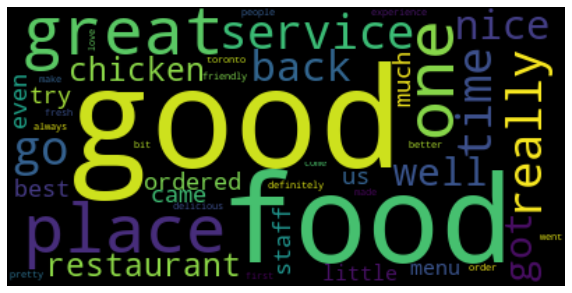

Cluster 2


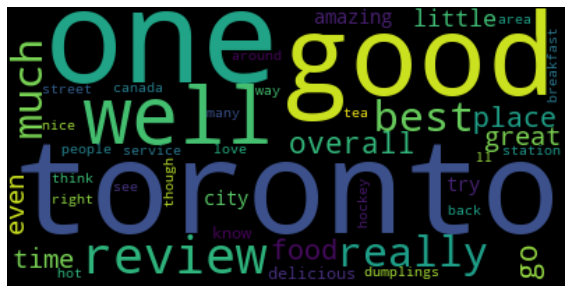

Cluster 3


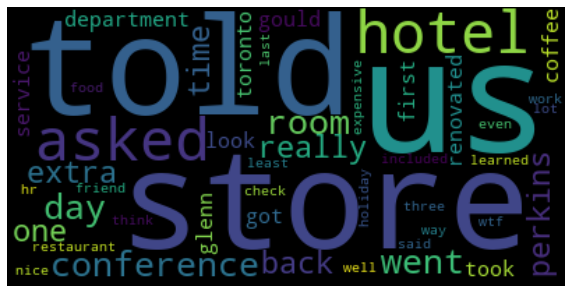

Cluster 4


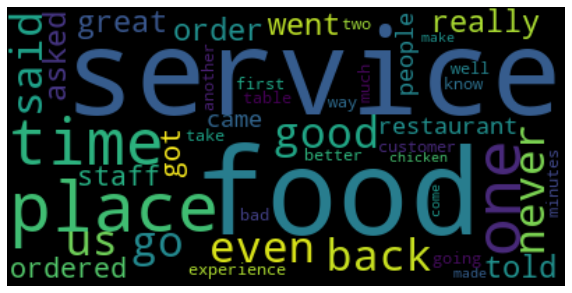

Cluster 5


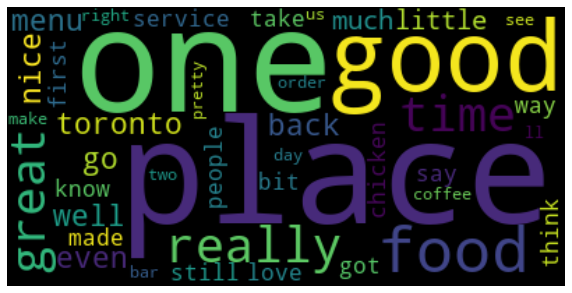

Cluster 6


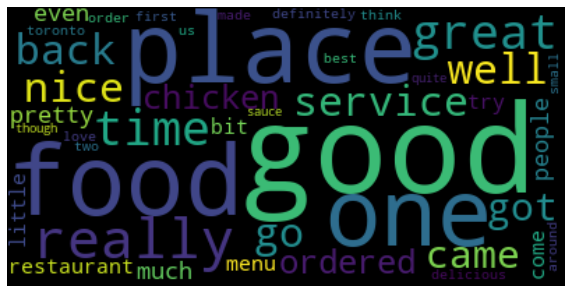

Cluster 7


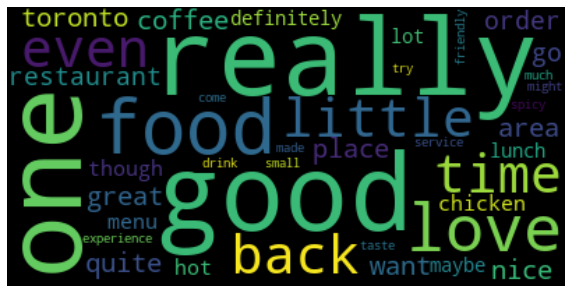

Cluster 8


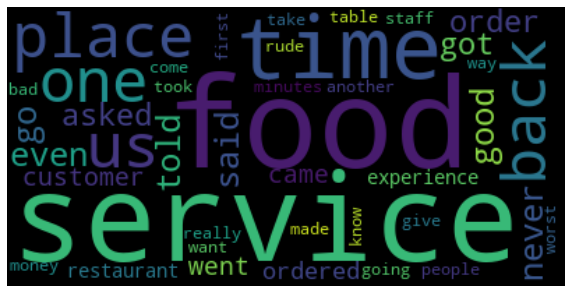

Cluster 9


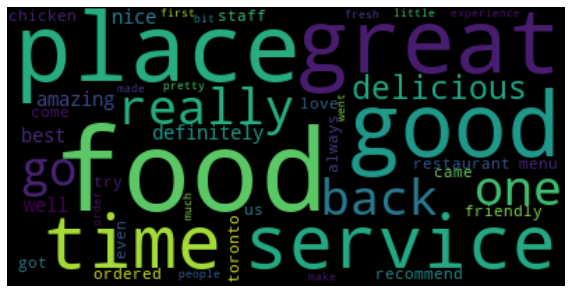

Cluster 10


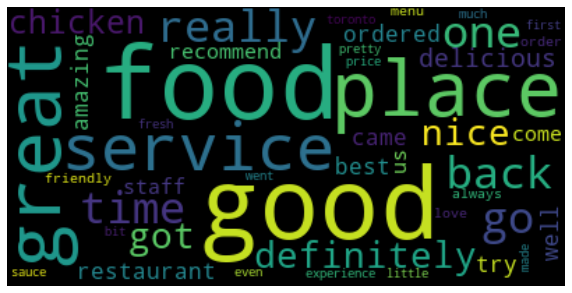

In [110]:
cluster = 1
for cl in cls:
    print(f"Cluster {cluster}")
    plt.figure(figsize=(10, 10))
    plt.imshow(WordCloud().generate(str(cl).replace("'", "")), interpolation='bilinear')
    plt.axis('off')
    plt.show()
    cluster += 1

## Concatenando Comentários por Usuário - Review + Tips

In [109]:
base9 = base8.withColumn('rv_tip', f.concat(
    f.col('text_clean'), f.lit(' '), f.col('tip_clean')))

NameError: name 'base8' is not defined

In [ ]:
# base9.select('text_clean','tip_clean','rv_tip','stars_rv','compliment_count_tip','funny_rv','cool_rv').show()

In [ ]:
base9.createOrReplaceTempView('base9')

In [ ]:
# spark.sql('''
#         SELECT stars_rv, count(tip_clean) as tip_counter
#         FROM base9
#         GROUP BY stars_rv
#         ORDER BY tip_counter DESC
#         ''').show()

- Remoção de colunas que não serão utilizadas na primeira modelagem

In [ ]:
base_final = base9.drop('friends_usr', 'friends_counter_usr', 'name_usr', 'city_bz', 'address_bz',
                        'state_bz', 'hours_bz', 'text_rv', 'tip', 'tip_clean', 'elite_usr')  # ,'review_id')

In [ ]:
base_final.columns

## Salva Base analítica em CSV

In [ ]:
base_final.write \
    .format('csv') \
    .mode('overwrite') \
    .option('sep', ',') \
    .option('header', True) \
    .save('output/yelp.csv')

# Base para Modelo de Tópicos

Informações de Texto que serão tratadas em Modelos de Tópicos no R

In [ ]:
words = base_final.select('review_id', 'user_id',
                          'business_id', 'categories_bz', 'stars_rv', 'rv_tip')

In [ ]:
words2 = words.withColumn('category_bz', f.explode(
    f.split(f.col('categories_bz'), ', ')))

In [ ]:
words3 = words2.drop('categories_bz')

In [ ]:
# words3.show()

In [ ]:
#words4 = words3.withColumn('word', f.explode(f.split(f.col('review_tip'),' ')))

## Salva Base Auxiliar para Modelo de Tópicos - "Reviews + Tips"

In [ ]:
words3.write \
    .format('csv') \
    .mode('overwrite') \
    .option('sep', ',') \
    .option('header', True) \
    .save('output/yelp_words.csv')

# Matriz de distâncias

Estruturação de Dados para Clusterização Hierárquica

- Preparação para criação de matriz de distâncias baseada na nota de cada avaliação.

In [ ]:
dist1 = base_final.select('user_id', 'categories_bz', 'stars_rv')

In [ ]:
# dist1.show()

In [68]:
dist2 = dist1.withColumn('category_bz', f.explode(
    f.split(f.col('categories_bz'), ', ')))

NameError: name 'dist1' is not defined

In [ ]:
# dist2.show()

In [ ]:
dist2.createOrReplaceTempView('dist')

- Quantidade de usuários e estabelecimentos

In [69]:
# spark.sql('''
#             SELECT Count(DISTINCT user_id)
#             FROM dist
#             ''').show()

In [70]:
# spark.sql('''
#             SELECT Count(DISTINCT categories_bz)
#             FROM dist
#             ''').show()

In [71]:
# spark.sql('''
#             SELECT Count(DISTINCT category_bz)
#             FROM dist
#             ''').show()

- Aumentando o limite máximo de coluna de acordo com o número de estabelecimentos

In [72]:
#spark.conf.set('spark.sql.pivotMaxValues', u'21000')

In [73]:
dist3 = dist2.groupBy("user_id").pivot("category_bz").mean("stars_rv")

NameError: name 'dist2' is not defined

In [74]:
dist4 = dist3.fillna(0)

NameError: name 'dist3' is not defined

In [ ]:
# dist4.show()

## Salva Base Auxiliar para Matriz de Distâncias - "Category"

In [75]:
dist4.write \
    .format('csv') \
    .mode('overwrite') \
    .option('sep', ',') \
    .option('header', True) \
    .save('output/yelp_dist.csv')

NameError: name 'dist4' is not defined

# Análise Gráfica

## Heatmap

- Criando mapa de calor da concentração de reviews

In [ ]:
base_mapas = spark.sql('''
                SELECT A.*, B.latitude, B.longitude
                
                FROM bz22 as B
                LEFT JOIN words as A

                ON A.business_id = B.business_id
                                
                ''')

In [ ]:
base_mapas.columns

In [ ]:
base_mapas.createOrReplaceTempView('base_mapas')

In [ ]:
mapa1 = spark.sql("""
        SELECT latitude,
        longitude
        
        FROM base_mapas
        
        WHERE latitude is not null
        AND longitude is not null
        
        """)

Decobrindo o ponto central de Latitude e Longetude do Mapa

In [ ]:
spark.sql("""
         SELECT avg(latitude) as avg_lat,
         avg(longitude) as avg_long
       
         FROM base_mapas
       
         """).show()

In [ ]:
import folium
from folium import plugins

mapa = folium.Map(location=[43.673, -79.391],
                  zoom_start=11,
                  tiles='Stamen Toner')
# OpenStreetMap, Stamen Terrain, Stamen Toner

In [ ]:
mapa

lat = mapa1.toPandas()['latitude'].values
lon = mapa1.toPandas()['longitude'].values

In [ ]:
coordenadas = []
for la, lo in zip(lat, lon):
    coordenadas.append([la, lo])
mapa.add_child(plugins.HeatMap(coordenadas))